<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q1
    Instructor: Kris                          TAs: Wen-Hsuan (Lead), Zen, Yan, Rawal, Paritosh, Qichen

In [1]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q1: Lucas-Kanade Forward Additive Alignment for Tracking

### Overview
In this part, you will implement two variants of the Lucas-Kanade Tracking algorithm:

- The warp $W$ being translation only
- The warp $W$ being the full affine transformation

and evaluate them on the provided videos, which can be downloaded [here](https://www.dropbox.com/sh/l2ip26mkgf5p3e6/AACN2STT5Sk9r6bPeEXIYKZCa?dl=0). It is highly recommended that you finish the theory section first, or at the very least, go over the provided materials to gain a better understanding of the algorithms. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).


### Q1.1:  Lucas-Kanade Forward Additive Alignment with Translation Only (10 PT write-up, 20 PT implementation)
Write the function with the following function signature:

```
            p = LucasKanade(It, It1, rect, thresh, maxIt)
```
that computes the optimal local motion $p$ represented by translation (motion in x and y directions) from frame $I_t$ to frame $I_{t+1}$that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

"It" is the image frame $I_t$, "It1" is the image frame $I_{t+1}$, and "rect" is a $4×1$ vector that represents a rectangle (bounding box) on the image frame $I_t$. The four elements of the rectangle are $[x1, y1, x2, y2]$, where $(x1, y1)$ is the top-left corner and $(x2, y2)$ is the bottom-right corner of the bounding box. "thresh" and "maxIt" control when the algorithm should stop, depending on if dp is too small or the maximum number of iterations has been reached, respectively.

Hints:
- To deal with the fractional movement of the template in the bounding box, you will need to interpolate the image using scipy.interpolate.RectBivariateSpline. The same function can also be used to compute the gradient of an image at a point location.
- You will need to iterate the estimation in Equation 10 until the change in warp parameters $(dx, dy)$ is below a threshold or the number of iterations is too large.
- You can use np.linalg.lstsq to solve the least square problem in Equation 10.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [2]:
def aligned_rect_indices(rect, homogeneous=False):
    """
    TODO
    """
    # x = axis1, y = axis0
    x1, y1, x2, y2 = rect
    # Round to the nearest integer (should essentially be an integer to begin with)
    a0_range = int(y2 - y1 + 0.5)
    a1_range = int(x2 - x1 + 0.5)
    # TODO
    a0_values = np.arange(y1, y2).reshape(-1, 1)
    a0_vector = np.hstack((a0_values, np.ones(a0_values.shape) * x1))
    a1_values = np.arange(x1, x2).reshape(-1, 1)
    a1_vector = np.hstack((np.ones(a1_values.shape) * y1, a1_values))
    # If requested, add 1s on the end
    if homogeneous:
        a0_vector = np.hstack((a0_vector, np.ones((a0_vector.shape[0], 1))))
        a1_vector = np.hstack((a1_vector, np.ones((a1_vector.shape[0], 1))))
    return a0_vector, a1_vector


def translate_warp(p, rect, image, dx=0, dy=0):
    a0_vector, a1_vector = aligned_rect_indices(rect)
    # This is the translational warp, specifically
    a0_warped = (a0_vector + p)[:, 0]
    a1_warped = (a1_vector + p)[:, 1]
    # Return specific warped values
    spline = RectBivariateSpline(
        x=np.array(range(image.shape[0])),
        y=np.array(range(image.shape[1])),
        z=image,
    )
    query = spline(
        x=a0_warped,
        y=a1_warped,
        dx=dx,
        dy=dy,
    )
    return query


def plot_impatch(image, rect, figsize=None):
    figure = plt.figure(figsize=figsize)
    axis = figure.add_subplot(111)
    axis.add_patch(patches.Rectangle((rect[0], rect[1]),
                                     rect[2]-rect[0]+1,
                                     rect[3]-rect[1]+1,
                                     linewidth=2,
                                     edgecolor='red',
                                     fill=False))
    axis.imshow(image, cmap='gray')
    plt.show()
    axis.clear()

    
def new_rect(rect, p):
    dx, dy = p
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    return np.array([rect[0] + dy,
                     rect[1] + dx,
                     rect[0] + dy + w,
                     rect[1] + dx + h])

In [3]:
def LucasKanade(It, It1, rect, thresh=0.025, maxIt=100):
    
    '''
    Q1.1: Lucas-Kanade Forward Additive Alignment with Translation Only
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        p: movement vector dx, dy
    '''
    import cv2
    
    # Set thresholds (you probably want to play around with the values)
    p = np.zeros(2) # dx, dy
    threshold = thresh
    maxIters = maxIt
    i = 0

    # # Use to visualize the images and the starting bounding boxes
    # plotim = It.copy()
    # cv2.rectangle(img=plotim, pt1=(x1, y1), pt2=(x2, y2), color=255, thickness=3)
    # a0vec, a1vec = aligned_rect_indices(rect)
    # plotim[a0vec.astype(int)[:, 0], a0vec.astype(int)[:, 1]] = 0
    # plotim[a1vec.astype(int)[:, 0], a1vec.astype(int)[:, 1]] = 0
    # plt.imshow(plotim)
    # plt.show()
    # plt.imshow(It1)
    # plt.show()

    # ----- TODO -----
    # YOUR CODE HERE

    # Get the template patch once
    template = translate_warp(p=np.array([0, 0]), rect=rect, image=It)
    # # Compute the gradient over the whole current image
    # It1_x = cv2.Scharr(src=It1, ddepth=-1, dx=1, dy=0)
    # It1_y = cv2.Scharr(src=It1, ddepth=-1, dx=0, dy=1)

    # # Use to visualize the patches
    # plt.imshow(It[y1:y2, x1:x2]); plt.show()
    # plt.imshow(It1[y1:y2, x1:x2]); plt.show()
    # plt.imshow(translate_warp(np.array([10, -20]), rect, It1)); plt.show()
    # import ipdb; ipdb.set_trace()

    for _ in range(maxIters):
        # Get warps with the new p
        warped_patch = translate_warp(p, rect, It1)
        # Unsolved mystery - is the interpolated cv2 filter on Ix Iy bad? It don't match
        # warped_Ix = translate_warp(p, rect, It1_x)
        # warped_Iy = translate_warp(p, rect, It1_y)
        warped_Ix = translate_warp(p, rect, It1, dx=1)
        warped_Iy = translate_warp(p, rect, It1, dy=1)
        
        # if _ % 20 == 0:
        #     plt.imshow(template); plt.title("Template"); plt.show()
        #     plt.imshow(warped_patch); plt.title("warped_patch"); plt.show()
        #     plt.imshow(warped_Ix); plt.title("warped_Ix"); plt.show()
        #     plt.imshow(warped_Iy); plt.title("warped_Iy"); plt.show()
        
        # In this specific case, dW/dp = I and we can get grad(Im)dW/dp
        # just with grad(Im)
        grad_I_dWdp = np.vstack((warped_Ix.flatten(), warped_Iy.flatten()))
        
        # Get the T(x) - I(W(x, p)) term
        error = template.flatten() - warped_patch.flatten()
        
        # Combine terms and sum
        descent_vector = np.sum(grad_I_dWdp * error, axis=1)
        # Did some whiteboard math to convince me this was equivalent to the
        # presented sum
        H = grad_I_dWdp @ grad_I_dWdp.T

        delta_p = np.linalg.inv(H) @ descent_vector
        p += delta_p
        if np.allclose(delta_p, 0, atol=threshold):
            # print(f"Breaking! p: {p}, delta_p: {delta_p}")
            break
        # print(f"p: {p}, delta_p: {delta_p}")

    # They want this returned in the opposite order that I would expect,
    # (axis1, axis0). I found it easiest to invert here rather than
    # invert the translate_warp function
    return p[::-1]


# # Exploration for what RectBivariateSpline is doing
# x = np.array([ 1, 1.5, 2, 4,   6, 6.5,   7, 7.5, 8, 8.5, 9, 9.5])
# y = np.array([0.5, 1, 1.5,   2, 2.5,   3, 5,   7, 8, 9])
# z = np.outer(np.array(range(12)), np.array(range(10, 20)))
# spline = RectBivariateSpline(range(12), range(10), z)
# output = spline(x, y)
# print(x)
# print(y)
# print(z)
# print(output)

# # Visualize images and bounding boxes
# for data_name in ["car1", "car2", "landing", "race", "ballet"]:
#     print(f"data_name: {data_name}")
#     data = np.load('./data/%s.npy' % data_name)
#     if data_name == 'car1':      initial = np.array([170, 130, 290, 250])
#     elif data_name == 'car2':    initial = np.array([59, 116, 145, 151])
#     elif data_name == 'landing': initial = np.array([440, 80, 560, 140])
#     elif data_name == 'race':    initial = np.array([170, 270, 300, 370])
#     elif data_name == 'ballet':  initial = np.array([700, 210, 775, 300])
#     else: assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'
#     numFrames = data.shape[2]
#     It = data[:,:,0]
#     It1 = data[:,:,1]
#     p = LucasKanade(It, It1, initial).astype(int)

#     import cv2
#     x1, y1, x2, y2 = initial
#     plotim = It1.copy()
#     cv2.rectangle(img=plotim,
#                   pt1=(x1+p[0], y1+p[1]),
#                   pt2=(x2+p[0], y2+p[1]),
#                   color=255,
#                   thickness=3)
#     plt.imshow(plotim)
#     plt.show()

# # Explore for a shifted image
# data_name = "car2"
# data = np.load('./data/%s.npy' % data_name)
# initial = np.array([59, 116, 145, 151])
# numFrames = data.shape[2]
# It = data[:,:,0]
# # Construct a modified It as It1 for different positive offsets
# for p0, p1 in ((7, 15), (2, 5), (17, 1), (15, 11)):
#     It1 = np.zeros(It.shape, dtype=np.uint8)
#     It1[p0:, p1:] = It[:-p0, :-p1]
#     plot_impatch(It, initial)
#     plot_impatch(It1, new_rect(initial, (p0, p1)))
#     # THEN call image alignment on it
#     calc_p = LucasKanade(It, It1, initial)
#     print(f"{calc_p} is close to ({p1}, {p0})? {np.allclose(calc_p, (p1, p0))}")
# # Again for negatives?
# for p0, p1 in ((-7, -15), (-2, -5), (-14, -1), (-12, -15)):
#     It1 = np.zeros(It.shape, dtype=np.uint8)
#     It1[:p0, :p1] = It[-p0:, -p1:]
#     plot_impatch(It, initial)
#     plot_impatch(It1, new_rect(initial, (p0, p1)))
#     # THEN call image alignment on it
#     calc_p = LucasKanade(It, It1, initial)
#     print(f"{calc_p} is close to ({p1}, {p0})? {np.allclose(calc_p, (p1, p0))}")

In [6]:
# Test your algorithm and visualize results!

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
# for data_name in ["race", "ballet"]:
# for data_name in ["race"]:
for data_name in ["car1", "car2", "landing", "race", "ballet"]:
    print("\ndata_name")
    data = np.load('./data/%s.npy' % data_name)

    # obtain the initial rect with format (x1, y1, x2, y2)
    if data_name == 'car1':
        initial = np.array([170, 130, 290, 250])
    elif data_name == 'car2':
        initial = np.array([59, 116, 145, 151])
    elif data_name == 'landing':
        initial = np.array([440, 80, 560, 140])
    elif data_name == 'race':
        initial = np.array([170, 270, 300, 370])
    elif data_name == 'ballet':
        initial = np.array([700, 210, 775, 300])
    else:
        assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

    numFrames = data.shape[2]
    w = initial[2] - initial[0]
    h = initial[3] - initial[1]

    # loop over frames
    rects = []
    rects.append(initial)

    for i in range(numFrames-1):

        It = data[:,:,i]
        It1 = data[:,:,i+1]
        rect = rects[i]

        # run algorithm and collect rects
        dx, dy = LucasKanade(It, It1, rect)
        newRect = np.array([rect[0] + dx, rect[1] + dy, rect[0] + dx + w, rect[1] + dy + h])
        rects.append(newRect)

        # Visualize
        fig = plt.figure(1, figsize=(12, 12))
        ax = fig.add_subplot(111)
        ax.add_patch(patches.Rectangle((rect[0], rect[1]),
                                       rect[2]-rect[0]+1,
                                       rect[3]-rect[1]+1,
                                       linewidth=2,
                                       edgecolor='red',
                                       fill=False))
        plt.imshow(It1, cmap='gray')
        plt.savefig(f"./vis/{data_name}_{i}.png")
        plt.close(fig)
        print(f"{i} ", end="")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26

In [4]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q1.2:  Lucas-Kanade Forward Additive Alignment with Affine Transformation (10 PT write-up, 20 PT implementation)
Assuming that the warp is translation-only is quite limiting. Now we will assume that the warp takes on the form of an arbitrary affine transformation. Write the function with the following function signature:

```
            M = LucasKanadeAffine(It, It1, rect):
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to the previous problem.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [58]:
def make_affine(M):
    A = M.copy()
    A[0, 0] += 1
    A[1, 1] += 1
    return A


def make_dWdp(x, y):
    return np.array([
        [x, 0, y, 0, 1, 0],
        [0, x, 0, y, 0, 1],
    ])


def affine_warp(M, rect, image, dx=0, dy=0):
    a0_vector, a1_vector = aligned_rect_indices(rect, homogeneous=True)
    # Affine warp on all these points
    A = make_affine(M)
    a0_warped = (A @ a0_vector.T).T
    a1_warped = (A @ a1_vector.T).T
    # Then grab only the specific columns
    # TODO: Debug these values with plots once we get to modified M
    a0_warped = a0_warped[:, 0]
    a1_warped = a1_warped[:, 1]
    # Return specific warped values
    spline = RectBivariateSpline(
        x=np.array(range(image.shape[0])),
        y=np.array(range(image.shape[1])),
        z=image,
    )
    query = spline(
        x=a0_warped,
        y=a1_warped,
        dx=dx,
        dy=dy,
    )
    return query, np.meshgrid(a0_warped, a1_warped)


def plot_impoly(image, rect, M, figsize=None):
    import cv2
    corners = np.array([[rect[0], rect[1], 1],
                        [rect[0], rect[3], 1],
                        [rect[2], rect[3], 1],
                        [rect[2], rect[1], 1]]).T
    warped_corners = (M @ corners).T
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.polylines(img=image,
                          pts=[warped_corners.astype(np.int32).reshape((-1, 1, 2))],
                          isClosed=True,
                          color=(255, 0, 0),
                          thickness=4)
    figure = plt.figure(figsize=figsize)
    axis = figure.add_subplot(111)
    axis.imshow(image)
    plt.show()
    axis.clear()

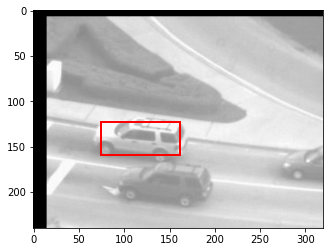

0
10
20


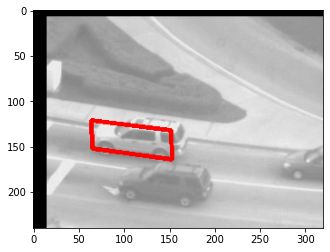

[[1.02349974 0.01630197 2.63873261]
 [0.13473575 0.89557761 9.27551402]] is close to ([[ 1  0  7]
 [ 0  1 15]])? False


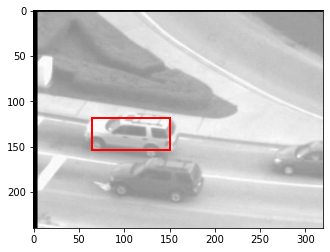

0
10
20


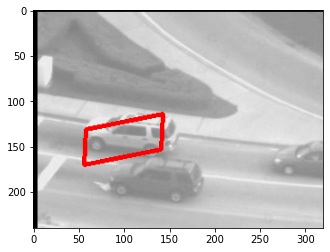

[[ 0.98836283 -0.06461552  7.56670676]
 [-0.19833939  1.13036026 11.78263647]] is close to ([[1 0 2]
 [0 1 5]])? False


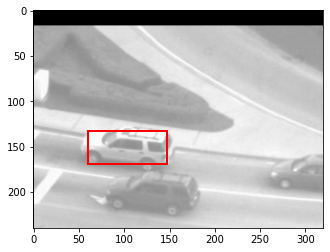

0
10
20


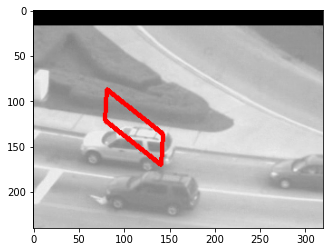

[[  0.72160187  -0.06906492  46.92043714]
 [  0.57172065   0.97090616 -59.30722545]] is close to ([[ 1  0 17]
 [ 0  1  1]])? False


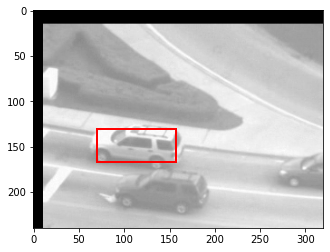

0
10
20


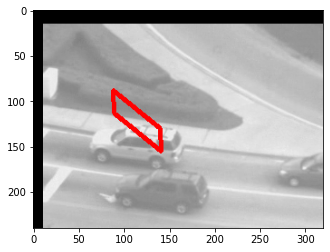

[[ 6.05325491e-01  2.25904732e-02  5.05779335e+01]
 [ 4.84869869e-01  7.18941042e-01 -2.34435780e+01]] is close to ([[ 1  0 15]
 [ 0  1 11]])? False


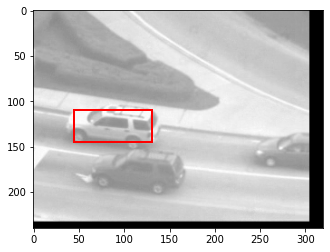

0
10
20


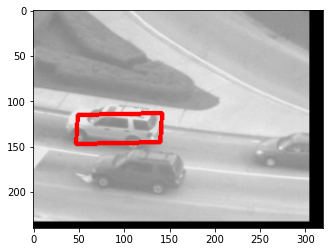

[[ 6.05325491e-01  2.25904732e-02  5.05779335e+01]
 [ 4.84869869e-01  7.18941042e-01 -2.34435780e+01]] is close to ([[  1   0  -7]
 [  0   1 -15]])? False


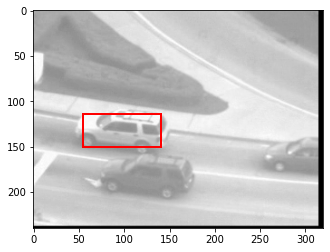

0


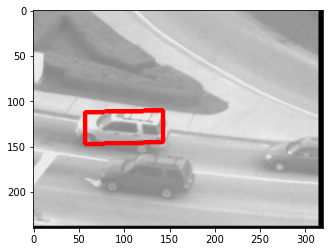

[[ 6.05325491e-01  2.25904732e-02  5.05779335e+01]
 [ 4.84869869e-01  7.18941042e-01 -2.34435780e+01]] is close to ([[ 1  0 -2]
 [ 0  1 -5]])? False


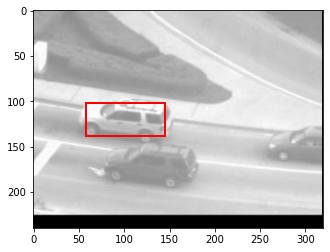

0
10
20


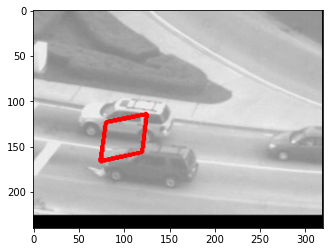

[[ 6.05325491e-01  2.25904732e-02  5.05779335e+01]
 [ 4.84869869e-01  7.18941042e-01 -2.34435780e+01]] is close to ([[  1   0 -14]
 [  0   1  -1]])? False


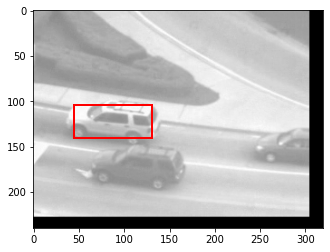

0
10
20


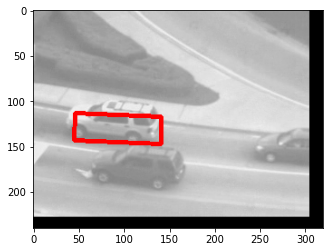

[[ 6.05325491e-01  2.25904732e-02  5.05779335e+01]
 [ 4.84869869e-01  7.18941042e-01 -2.34435780e+01]] is close to ([[  1   0 -12]
 [  0   1 -15]])? False


In [79]:
M_IDENTITY = np.array([[1, 0, 0], [0, 1, 0]])


def LucasKanadeAffine(It, It1, rect, thresh=.025, maxIt=25):
    '''
    Q1.2: Lucas-Kanade Forward Additive Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''

    import cv2
    
    # Set thresholds (you probably want to play around with the values)
    M = np.zeros((2,3))
    threshold = thresh
    maxIters = maxIt
    x1, y1, x2, y2 = rect

    # ----- TODO -----
    # YOUR CODE HERE

    # Use to visualize the images and the starting bounding boxes
    # plot_impoly(It, rect, M_IDENTITY)
    # plot_impoly(It1, rect, M_IDENTITY)
    
    # Get the template patch once
    template, _ = affine_warp(M=np.zeros((2,3)), rect=rect, image=It)

    for i in range(maxIters):
        # Get warps with the new p
        warped_patch, (X, Y) = affine_warp(M, rect, It1)
        warped_Ix, _ = affine_warp(M, rect, It1, dx=1)
        warped_Iy, _ = affine_warp(M, rect, It1, dy=1)
        
        if i % 10 == 0:
            print(i)
        #     plt.imshow(template); plt.title("Template"); plt.show()
        #     plt.imshow(warped_patch); plt.title("warped_patch"); plt.show()
        #     plt.imshow(warped_Ix); plt.title("warped_Ix"); plt.show()
        #     plt.imshow(warped_Iy); plt.title("warped_Iy"); plt.show()

        # Get the T(x) - I(W(x, p)) term
        error = template.flatten() - warped_patch.flatten()

        # Do it the slow way first. Can this even be sped up significantly since
        # we have to slowly construct dWdp either way?
#         grad_I = np.vstack((warped_Iy.flatten(), warped_Ix.flatten())).T
        grad_I = np.vstack((warped_Ix.flatten(), warped_Iy.flatten())).T
        grad_I_dWdp = []
        for grad_I_xy, x, y in zip(grad_I, X.flatten(), Y.flatten()):
            dWdp = make_dWdp(y, x) # dWdp = make_dWdp(x, y)
            grad_I_dWdp.append(grad_I_xy @ dWdp)
        grad_I_dWdp = np.array(grad_I_dWdp).T
        
#         # Now we need to do a complicated multiplication and sum, but in a
#         # vectorized way. Let's start by multiplying in the error (scalar) terms,
#         # then converting to a (N, 2) matrix
#         grad_I = np.vstack((warped_Ix.flatten(), warped_Iy.flatten()))
#         scaled_grad_I = grad_I * error
#         scaled_grad_I = scaled_grad_I.T
        
#         # Now construct a large matrix of the dWdp terms, which have to be
#         # specific to each point. It's important that the flattened points
#         # used here match those in the error terms
#         dWdp = construct_jacobian_matrix
#         import ipdb; ipdb.set_trace()
#         # grad_I_dWdp =
        
        # Combine terms and sum
        descent_vector = np.sum(grad_I_dWdp * error, axis=1)
        # Did some whiteboard math to convince me this was equivalent to the
        # presented sum
        H = grad_I_dWdp @ grad_I_dWdp.T

        # Solve for the 6 parameters and reshape into a proper delta
        delta_M_vector = np.linalg.inv(H) @ descent_vector
        delta_M = np.array([
            [delta_M_vector[0], delta_M_vector[2], delta_M_vector[4]],
            [delta_M_vector[1], delta_M_vector[3], delta_M_vector[5]],
        ])
        M += delta_M

        if np.allclose(delta_M, 0, atol=threshold):
            # print(f"Breaking! M: {M}, delta_M: {delta_M}")
            break
        # print(f"M: {M}, delta_M: {delta_M}")

    plot_impoly(It1, rect, make_affine(M))  # cv2.warpAffine(image, M, image.shape[::-1])
    return make_affine(M)


# # Visualize images and bounding boxes
# for data_name in ["car1", "car2", "landing", "race", "ballet"]:
#     print(f"data_name: {data_name}")
#     data = np.load('./data/%s.npy' % data_name)
#     if data_name == 'car1':      initial = np.array([170, 130, 290, 250])
#     elif data_name == 'car2':    initial = np.array([59, 116, 145, 151])
#     elif data_name == 'landing': initial = np.array([440, 80, 560, 140])
#     elif data_name == 'race':    initial = np.array([170, 270, 300, 370])
#     elif data_name == 'ballet':  initial = np.array([700, 210, 775, 300])
#     else: assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'
#     numFrames = data.shape[2]
#     It = data[:,:,0]
#     It1 = data[:,:,1]
#     M = LucasKanadeAffine(It, It1, initial)
#     plot_impoly(It1, initial, M)


# Explore for a shifted image
data_name = "car2"
data = np.load('./data/%s.npy' % data_name)
initial = np.array([59, 116, 145, 151])
numFrames = data.shape[2]
It = data[:,:,0]
def translate_M(p0, p1):
    return np.array([[1, 0, p0], [0, 1, p1]])
# Construct a modified It as It1 for different positive offsets
for p0, p1 in ((7, 15), (2, 5), (17, 1), (15, 11)):
    It1 = np.zeros(It.shape, dtype=np.uint8)
    It1[p0:, p1:] = It[:-p0, :-p1]
#     plot_impatch(It, initial)
    plot_impatch(It1, new_rect(initial, (p0, p1)))
    # THEN call image alignment on it
    calc_M = LucasKanadeAffine(It, It1, initial)
    print(f"{calc_M} is close to ({translate_M(p0, p1)})? {np.allclose(calc_M, translate_M(p0, p1))}")
# Again for negatives?
for p0, p1 in ((-7, -15), (-2, -5), (-14, -1), (-12, -15)):
    It1 = np.zeros(It.shape, dtype=np.uint8)
    It1[:p0, :p1] = It[-p0:, -p1:]
#     plot_impatch(It, initial)
    plot_impatch(It1, new_rect(initial, (p0, p1)))
    # THEN call image alignment on it
    calc_p = LucasKanadeAffine(It, It1, initial)
    print(f"{calc_M} is close to ({translate_M(p0, p1)})? {np.allclose(calc_M, translate_M(p0, p1))}")


0
10


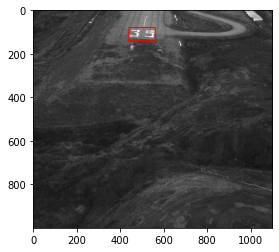

0
10
20


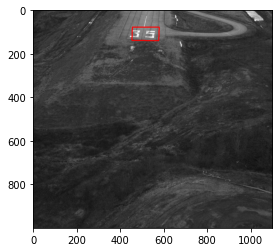

0
10
20


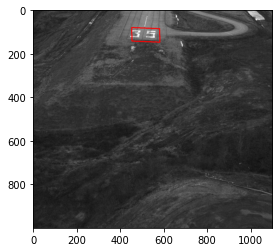

0
10
20


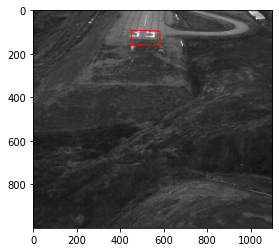

In [68]:
# Test your algorithm and visualize results!

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])   
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])    
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])     
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])     
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

# for i in range(numFrames-1):
for i in range(4):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    M = LucasKanadeAffine(It, It1, rect)
    corners = np.array([[rect[0], rect[1], 1], 
                        [rect[2], rect[3], 1]]).transpose()
    newRect = np.matmul(M, corners).transpose().reshape((4, ))
    rects.append(newRect)

#     # Visualize
#     fig = plt.figure(1)
#     ax = fig.add_subplot(111)
#     ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
#     plt.imshow(It1, cmap='gray')
#     plt.show()
#     ax.clear()


In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.
